# GF-KSD: Convergence Detection (Figure 1)

In [1]:
import torch
import numpy as np
import torch.distributions as D

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
style.use("seaborn-white")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from pylab import rcParams
rcParams['figure.figsize'] = 10,6
import numpy as np

from steintorch.utils.get_score import get_score
from steintorch.utils.dist_approximations import get_gaussian_mixture_approximation, get_laplace_approximation, get_kernel_density_approximation
from steintorch.kernel import SquaredExponentialKernel
from steintorch.utils.cdf import get_1D_mixture_cdf, get_icdf
from steintorch.distribution.base import Distribution

In [2]:
weights = torch.Tensor([0.6,0.9,0.1])
mean_vec = torch.Tensor([[-0.4],[0.3],[0.06]])
var_vec = torch.Tensor([[0.2],[0.2],[0.9]])

mix = D.Categorical(weights)
normal = D.Normal(mean_vec, var_vec)
comp = D.Independent(normal, 1)
P = D.MixtureSameFamily(mix, comp)
P.cdf = get_1D_mixture_cdf(normal,weights)  # make the target P have a well defined CDF

## Defining Sequences

In [3]:
from pystein.distribution.base import Distribution

def scale_sequence(u, target_dist=P):
    Q_n = Distribution()

    location, scale = u

    def sample_Q_n(n=None, samps=None):
        if samps is None:
            return target_dist.sample(n) * scale + location
        else:
            return samps * scale + location

    def log_prob_Q_n(x):
        return target_dist.log_prob( (x-location) / scale) - torch.log(scale)

    def cdf_Q_n(x):
        return target_dist.cdf((x-location) / scale)

    icdf_Q_n = get_icdf(cdf_Q_n, log_prob=log_prob_Q_n)

    Q_n.sample = sample_Q_n
    Q_n.log_prob = log_prob_Q_n
    Q_n.cdf = cdf_Q_n
    Q_n.icdf = icdf_Q_n

    return Q_n

def phi_increasing_scale(n):
    return torch.Tensor([0,1 - 1 / (n+1.9)])

def phi_decreasing_scale(n):
    return torch.Tensor([0,1 + 2 / (n+1)])

def phi_decreasing_location(n):
    return torch.Tensor([5 / (n + 4),1])

def phi_mix(n):
    return torch.Tensor([-5 / (n + 4) ** 1.5,1 + 2 / (n+1) ** 1.5 + torch.sin(torch.Tensor([n])) * 1/(n+1) ** 1.5])

def phi_linear_increasing_location(n):
    return torch.Tensor([-4 + n/25, 1])

## Defining $q$ and GF-KSD

In [12]:
Q_prior.variance

tensor([0.5625])

GMM bic:  109.9792339105923


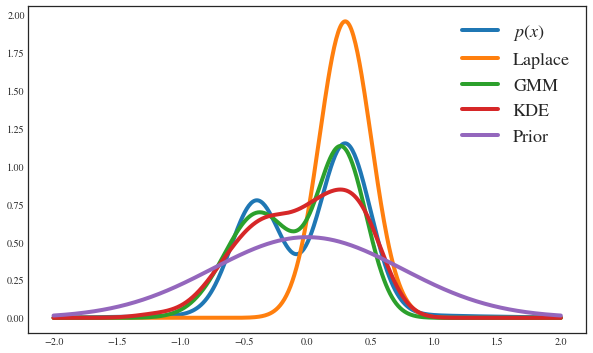

In [4]:
from pystein.utils.dist_approximations import get_gaussian_mixture_approximation, get_laplace_approximation, get_kernel_density_approximation
from pystein.kernel import MaternKernel, SquaredExponentialKernel
from pystein.utils.cdf import get_1D_mixture_cdf, get_icdf

kde_kernel = SquaredExponentialKernel(dim=1) # kernel for KDE

torch.manual_seed(3)
P_sample = P.sample((100,)) # sample used to generate approximations
Q_laplace = get_laplace_approximation(P, mode=torch.Tensor([0.3]))
Q_gmm, bic = get_gaussian_mixture_approximation(P_sample, N=2, evaluate="bic")
print("GMM bic: ", bic)

Q_kde = get_kernel_density_approximation(P_sample, kde_kernel)
Q_kde.silvermans_rule()

Q_prior = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([0.75]))

score_P = lambda sample: get_score(sample, P)
score_Q_laplace = lambda sample: get_score(sample, Q_laplace)
score_Q_gmm = lambda sample: get_score(sample, Q_gmm)
score_Q_kde = lambda sample: get_score(sample, Q_kde)
score_Q_prior = lambda sample: get_score(sample, Q_prior)

p = lambda x: P.log_prob(x)
q_laplace = lambda x: Q_laplace.log_prob(x)
q_gmm = lambda x: Q_gmm.log_prob(x)
q_kde = lambda x: Q_kde.log_prob(x)
q_prior = lambda x: Q_prior.log_prob(x)

LIN = torch.linspace(-2,2,500)
plt.plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=4)
plt.plot(LIN, Q_laplace.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=4)
plt.plot(LIN, Q_gmm.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=4)
plt.plot(LIN, Q_kde.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=4)
plt.plot(LIN, Q_prior.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=4)

plt.legend(["$p(x)$","Laplace","GMM","KDE", "Prior"], prop={'size': 18})
plt.show()


## Plotting Convergence

In [232]:
from pystein.divergence.ksd import GradientFreeKSD

gf_KSD = GradientFreeKSD(None)

In [233]:
M = 300 # mesh size

converging_sequences = [phi_increasing_scale, phi_decreasing_scale, phi_mix]
uniform_mesh = torch.linspace(0, 1, M + 2)[1:-1]

icdfP = get_icdf(P.cdf, log_prob=P.log_prob)
uniform_P_mesh = torch.Tensor(icdfP(uniform_mesh)).unsqueeze(1)

d:\dev\Anaconda3\envs\stein\lib\site-packages\scipy\optimize\zeros.py:459: RuntimeWarning: some failed to converge after 200 iterations
  warnings.warn(msg, RuntimeWarning)


In [234]:
from matplotlib import cm
import numpy as np

N = 100

In [235]:
cm_lin_space = np.linspace(0, 1, N) ** 0.2

def make_Ramp( ramp_colors ): 
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap
    N = 100
    cm_lin_space = np.linspace(0, 1, N) ** 0.2

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    # plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.imshow( [list(cm_lin_space * len(ramp_colors))], interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

good_ramp1 = make_Ramp( ['#19040F','#FF2D96' ] ) 
good_ramp2 =  make_Ramp( ['#191100','#FFB000' ] ) 
good_ramp3 = make_Ramp( ['#0A0E19','#648FFF' ] ) 

good_ramps = [good_ramp1, good_ramp2, good_ramp3]
# bad_ramps = [bad_ramp1, bad_ramp2, bad_ramp3]

In [ ]:
fig, axes = plt.subplots(2,3)
fig.set_size_inches(15, 6)

ls = "--"

plot_seqs_only = False # True

if plot_seqs_only is False:
    ksd_laplace_evals = [[] for  i in range(3)] # laplace
    ksd_gmm_evals = [[] for  i in range(3)] # gmm
    ksd_kde_evals = [[] for i in range(3)] # kde
    ksd_prior_evals = [[] for  i in range(3)] # prior
    ksd_true_evals = [[] for i in range(3)] # true

pp_compare_sample = P.sample((1000,))

for j in range(len(converging_sequences)):
    for i in range(N):

        Q_ij = scale_sequence(converging_sequences[j](i), target_dist=P)

        if plot_seqs_only is True:
            axes[0][j].plot(LIN, Q_ij.log_prob(LIN.unsqueeze(-1)).exp(), color=good_ramps[j](cm_lin_space[i]), linewidth=2)
        else:
            axes[0][j].plot(LIN, Q_ij.log_prob(LIN.unsqueeze(-1)).exp(), color=good_ramps[j](cm_lin_space[i]), linewidth=2)


            Q_ij_sample = Q_ij.sample(samps=uniform_P_mesh).requires_grad_(True) 
            
            ksd_laplace_evals[j].append(gf_KSD.eval(Q_ij_sample, p, q_laplace, score_Q_laplace).detach())
            ksd_gmm_evals[j].append(gf_KSD.eval(Q_ij_sample, p, q_gmm, score_Q_gmm).detach())
            ksd_kde_evals[j].append(gf_KSD.eval(Q_ij_sample, p, q_kde, score_Q_kde).detach())
            ksd_prior_evals[j].append(gf_KSD.eval(Q_ij_sample, p, q_prior, score_Q_prior).detach())
            ksd_true_evals[j].append(gf_KSD.eval(Q_ij_sample, p, p, score_P).detach())
            
            #axes[j].vlines(Q_ij_sample.detach().numpy(), ymin = -0.01,ymax=0)

    axes[0][j].plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), color="black", linewidth=4)

if plot_seqs_only is False:
    ksd_laplace_evals_BAD = [[] for  i in range(3)] # laplace
    ksd_gmm_evals_BAD = [[] for  i in range(3)] # gmm
    ksd_kde_evals_BAD = [[] for i in range(3)] # kde
    ksd_prior_evals_BAD = [[] for  i in range(3)] # prior
    ksd_true_evals_BAD = [[] for i in range(3)] # true

bad_pp_compare_sample = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([0.5])).sample((1000,))
uniform_badP_mesh = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([0.5])).icdf(uniform_mesh).unsqueeze(1)

for j in range(len(converging_sequences)):
    for i in range(N):
        Q_ij = scale_sequence(converging_sequences[j](i), target_dist=torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([0.5])))

        if plot_seqs_only is True:
            axes[1][j].plot(LIN, Q_ij.log_prob(LIN.unsqueeze(-1)).exp(), color=good_ramps[j](cm_lin_space[i]), linewidth=2, linestyle=ls)
        else:
            axes[1][j].plot(LIN, Q_ij.log_prob(LIN.unsqueeze(-1)).exp(), color=good_ramps[j](cm_lin_space[i]), linewidth=2, linestyle=ls)

                
            Q_ij_sample = Q_ij.sample(samps=uniform_badP_mesh).requires_grad_(True) 
            
            ksd_laplace_evals_BAD[j].append(gf_KSD.eval(Q_ij_sample, p, q_laplace, score_Q_laplace).detach().sqrt())
            ksd_gmm_evals_BAD[j].append(gf_KSD.eval(Q_ij_sample, p, q_gmm, score_Q_gmm).detach().sqrt())
            ksd_kde_evals_BAD[j].append(gf_KSD.eval(Q_ij_sample, p, q_kde, score_Q_kde).detach().sqrt())
            ksd_prior_evals_BAD[j].append(gf_KSD.eval(Q_ij_sample, p, q_prior, score_Q_prior).detach().sqrt())
            ksd_true_evals_BAD[j].append(gf_KSD.eval(Q_ij_sample, p, p, score_P).detach().sqrt())
        
        #axes[j].vlines(Q_ij_sample.detach().numpy(), ymin = -0.01,ymax=0)

    axes[1][j].plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), color="black", linewidth=4)



axes[0][0].set_title("Outward Convergence")
axes[0][1].set_title("Inward Convergence")
axes[0][2].set_title("Oblique Convergence")

axes[1][0].set_title("Outward Non-Convergence")
axes[1][1].set_title("Inward Non-Convergence")
axes[1][2].set_title("Oblique Non-Convergence")


axes[0][0].set_ylabel("Converging Sequences")
axes[1][0].set_ylabel("Non-Converging Sequences")

### Plot Sequences

C:\Users\matth\AppData\Local\Temp/ipykernel_6628/3507614008.py:62: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("sequence.pdf", bbox_inches = "tight", padding = 0)


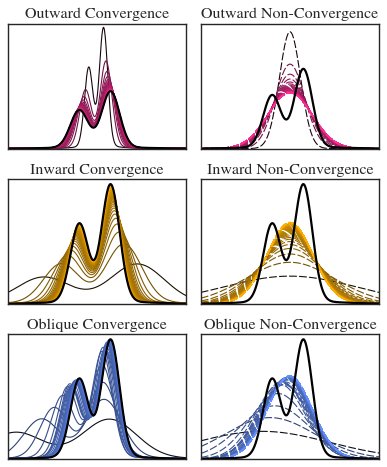

In [72]:
style.use('seaborn-white')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

fig, axes = plt.subplots(3,2)
fig.set_size_inches(5, 6)

ls = "--"

THICKNESS = 1

plot_seqs_only = True # True

if plot_seqs_only is False:
    ksd_laplace_evals = [[] for  i in range(3)] # laplace
    ksd_gmm_evals = [[] for  i in range(3)] # gmm
    ksd_kde_evals = [[] for i in range(3)] # kde
    ksd_prior_evals = [[] for  i in range(3)] # prior
    ksd_true_evals = [[] for i in range(3)] # true

for j in range(len(converging_sequences)):
    for i in range(N):
        Q_ij = scale_sequence(converging_sequences[j](i), target_dist=P)
        axes[j][0].plot(LIN, Q_ij.log_prob(LIN.unsqueeze(-1)).exp(), color=good_ramps[j](cm_lin_space[i]), linewidth=THICKNESS)

    axes[j][0].plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), color="black", linewidth=THICKNESS+1)


for j in range(len(converging_sequences)):
    for i in range(N):
        Q_ij = scale_sequence(converging_sequences[j](i), target_dist=torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([0.5])))
        axes[j][1].plot(LIN, Q_ij.log_prob(LIN.unsqueeze(-1)).exp(), color=good_ramps[j](cm_lin_space[i]), linewidth=THICKNESS, linestyle=ls, dashes=[7, 2])


    axes[j][1].plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), color="black", linewidth=THICKNESS+1)


axes[0][0].set_title("Outward Convergence")
axes[1][0].set_title("Inward Convergence")
axes[2][0].set_title("Oblique Convergence")

axes[0][1].set_title("Outward Non-Convergence")
axes[1][1].set_title("Inward Non-Convergence")
axes[2][1].set_title("Oblique Non-Convergence")

for i in range(3):
    #axes[i][1].set_xticks([])
    axes[i][1].xaxis.set_ticks_position('none') 
    axes[i][1].set_xticklabels([])
    #axes[i][0].set_xticks([])
    axes[i][0].xaxis.set_ticks_position('none') 
    axes[i][0].set_xticklabels([])

    #axes[i][1].set_yticks([])
    axes[i][1].yaxis.set_ticks_position('none') 
    axes[i][1].set_yticklabels([])
    axes[i][0].yaxis.set_ticks_position('none') 
    axes[i][0].set_yticklabels([])

fig.tight_layout()

fig.savefig("sequence.pdf", bbox_inches = "tight", padding = 0)
    

C:\Users\matth\AppData\Local\Temp/ipykernel_6628/3660748696.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\matth\AppData\Local\Temp/ipykernel_6628/3660748696.py:97: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("ksd_convergence_legend.pdf", bbox_inches = "tight", padding = 0)


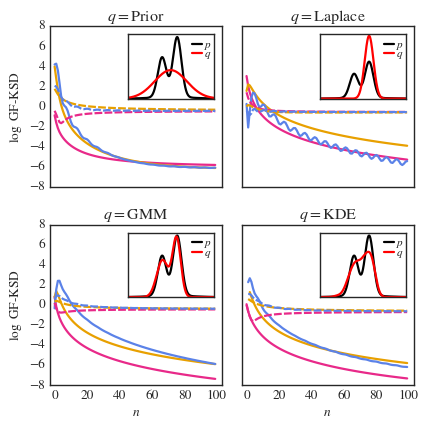

In [239]:
import matplotlib.transforms as mtrans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(2,2)
fig.set_size_inches(5.5, 5.5)

min_y, max_y = -8, 8
XX = torch.Tensor([j for j in range(N)])
plot_y_range = False
THICKNESS = 2

value_col = .9
colors = []

axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals[0]).detach().log(), linewidth=THICKNESS, color=good_ramps[0](value_col))
axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals[1]).detach().log(), linewidth=THICKNESS, color=good_ramps[1](value_col))
axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals[2]).detach().log(), linewidth=THICKNESS, color=good_ramps[2](value_col))
axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals_BAD[0]).detach().log(), linewidth=THICKNESS, color=good_ramps[0](value_col), linestyle=ls,  dashes=[7, 2])
axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals_BAD[1]).detach().log(), linewidth=THICKNESS, color=good_ramps[1](value_col), linestyle=ls, dashes=[7, 2])
axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals_BAD[2]).detach().log(), linewidth=THICKNESS, color=good_ramps[2](value_col), linestyle=ls, dashes=[7, 2])

for i in range(3):
    axes[1][0].plot(XX, torch.Tensor(ksd_gmm_evals[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[1][1].plot(XX, torch.Tensor(ksd_kde_evals[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[0][0].plot(XX, torch.Tensor(ksd_prior_evals[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))

for i in range(3):
    axes[1][0].plot(XX, torch.Tensor(ksd_gmm_evals_BAD[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])
    axes[1][1].plot(XX, torch.Tensor(ksd_kde_evals_BAD[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])
    axes[0][0].plot(XX, torch.Tensor(ksd_prior_evals_BAD[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])

axes[0][0].set_title("$q=$Prior")
axes[0][1].set_title("$q=$Laplace")
axes[1][0].set_title("$q=$GMM")
axes[1][1].set_title("$q=$KDE")

LIN = torch.linspace(-2,2,500)

axes[0][0].xaxis.set_ticklabels([])
axes[0][0].xaxis.set_ticks_position('none') 

axes[0][1].xaxis.set_ticklabels([])
axes[0][1].xaxis.set_ticks_position('none') 

axes[0][1].yaxis.set_ticklabels([])
axes[0][1].yaxis.set_ticks_position('none') 

axes[1][1].yaxis.set_ticklabels([])
axes[1][1].yaxis.set_ticks_position('none') 

axes[0][0].set_ylabel("$\log$ GF-KSD")
axes[1][0].set_ylabel("$\log$ GF-KSD")


axes[1][0].set_xlabel("$n$")
axes[1][1].set_xlabel("$n$")


for i in range(2):
    for j in range(2):
        axes[i][j].set_ylim(min_y,max_y)
        axes[i][j].set_xlim(-3,103)


# inset axes:

inset_width = '50%'
inset_height = '40%'
axins1 = inset_axes(axes[0][0], width=inset_width, height=inset_height, loc=1) #prior
axins1.plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label = '$p$', color="black")
axins1.plot(LIN, Q_prior.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label='$q$', color="red")
axins1.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

axins2 = inset_axes(axes[0][1], width=inset_width, height=inset_height, loc=1) #laplace
axins2.plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins2.plot(LIN, Q_laplace.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label="$q$", color="red")
axins2.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)


axins3 = inset_axes(axes[1][0], width=inset_width, height=inset_height, loc=1) #GMM
axins3.plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins3.plot(LIN, Q_gmm.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label="$q$", color="red")
axins3.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)


axins4 = inset_axes(axes[1][1], width=inset_width, height=inset_height, loc=1) #KDE
axins4.plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins4.plot(LIN, Q_kde.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label="$q$", color="red")
axins4.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

for axi in [axins1, axins2, axins3, axins4]:
    axi.tick_params(labelleft=False, labelbottom=False)


fig.tight_layout()

fig.savefig("ksd_convergence_legend.pdf", bbox_inches = "tight", padding = 0)


plt.show()


C:\Users\matth\AppData\Local\Temp/ipykernel_6628/2922749718.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\matth\AppData\Local\Temp/ipykernel_6628/2922749718.py:97: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("ksd_convergence.pdf", bbox_inches = "tight", padding = 0)


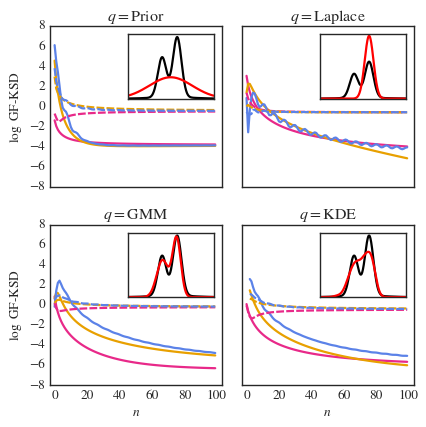

In [31]:
import matplotlib.transforms as mtrans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(2,2)
fig.set_size_inches(5.5, 5.5)

min_y, max_y = -8, 8
XX = torch.Tensor([j for j in range(N)])
plot_y_range = False
THICKNESS = 2

value_col = .9
colors = []

axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals[0]).detach().log(), linewidth=THICKNESS, color=good_ramps[0](value_col))
axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals[1]).detach().log(), linewidth=THICKNESS, color=good_ramps[1](value_col))
axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals[2]).detach().log(), linewidth=THICKNESS, color=good_ramps[2](value_col))
axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals_BAD[0]).detach().log(), linewidth=THICKNESS, color=good_ramps[0](value_col), linestyle=ls,  dashes=[7, 2])
axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals_BAD[1]).detach().log(), linewidth=THICKNESS, color=good_ramps[1](value_col), linestyle=ls, dashes=[7, 2])
axes[0][1].plot(XX, torch.Tensor(ksd_laplace_evals_BAD[2]).detach().log(), linewidth=THICKNESS, color=good_ramps[2](value_col), linestyle=ls, dashes=[7, 2])

for i in range(3):
    axes[1][0].plot(XX, torch.Tensor(ksd_gmm_evals[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[1][1].plot(XX, torch.Tensor(ksd_kde_evals[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[0][0].plot(XX, torch.Tensor(ksd_prior_evals[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))

for i in range(3):
    axes[1][0].plot(XX, torch.Tensor(ksd_gmm_evals_BAD[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])
    axes[1][1].plot(XX, torch.Tensor(ksd_kde_evals_BAD[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])
    axes[0][0].plot(XX, torch.Tensor(ksd_prior_evals_BAD[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), linestyle=ls,  dashes=[7, 2])

axes[0][0].set_title("$q=$Prior")
axes[0][1].set_title("$q=$Laplace")
axes[1][0].set_title("$q=$GMM")
axes[1][1].set_title("$q=$KDE")

LIN = torch.linspace(-2,2,500)

axes[0][0].xaxis.set_ticklabels([])
axes[0][0].xaxis.set_ticks_position('none') 

axes[0][1].xaxis.set_ticklabels([])
axes[0][1].xaxis.set_ticks_position('none') 

axes[0][1].yaxis.set_ticklabels([])
axes[0][1].yaxis.set_ticks_position('none') 

axes[1][1].yaxis.set_ticklabels([])
axes[1][1].yaxis.set_ticks_position('none') 

axes[0][0].set_ylabel("$\log$ GF-KSD")
axes[1][0].set_ylabel("$\log$ GF-KSD")


axes[1][0].set_xlabel("$n$")
axes[1][1].set_xlabel("$n$")


for i in range(2):
    for j in range(2):
        axes[i][j].set_ylim(min_y,max_y)
        axes[i][j].set_xlim(-3,103)


# inset axes:

inset_width = '50%'
inset_height = '40%'
axins1 = inset_axes(axes[0][0], width=inset_width, height=inset_height, loc=1) #prior
axins1.plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label = '$p$', color="black")
axins1.plot(LIN, Q_prior.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label='$q$', color="red")
# axins1.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

axins2 = inset_axes(axes[0][1], width=inset_width, height=inset_height, loc=1) #laplace
axins2.plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins2.plot(LIN, Q_laplace.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label="$q$", color="red")
# axins2.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)


axins3 = inset_axes(axes[1][0], width=inset_width, height=inset_height, loc=1) #GMM
axins3.plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins3.plot(LIN, Q_gmm.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS, label="$q$", color="red")
# axins3.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)


axins4 = inset_axes(axes[1][1], width=inset_width, height=inset_height, loc=1) #KDE
axins4.plot(LIN, P.log_prob(LIN.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins4.plot(LIN, Q_kde.log_prob(LIN.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label="$q$", color="red")
# axins4.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

for axi in [axins1, axins2, axins3, axins4]:
    axi.tick_params(labelleft=False, labelbottom=False)


fig.tight_layout()

fig.savefig("ksd_convergence.pdf", bbox_inches = "tight", padding = 0)


plt.show()
